# Water Rights Restored to the Gila River

The impacts of irrigation on vegetation health in the Gila River Valley

Elsa Culler  
Nate Quarderer  
2025-07-09

# STEP 2: Wrangle Raster Data

# STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r

You will also need to import any libraries you are using in this
notebook, since they won’t carry over from the previous notebook:

In [2]:
# Import libraries
import json
from glob import glob

import earthpy
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

## Load in NDVI data

Now you need to load all the downloaded files into Python. Let’s start
by getting all the file names. You will also need to extract the date
from the filename. Check out [the lesson on getting information from
filenames in the
textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/data-workflows-with-loops/).

Instead of writing out the names of all the files you want, you can use
the `glob` utility to find all files that match a **pattern** formed
with the **wildcard** character `*`. The wildcard can represent any
string of alphanumeric characters. For example, the pattern
`'file_*.tif'` will match the files `'file_1.tif'`, `'file_2.tiv'`, or
even `'file_qeoiurghtfoqaegbn34pf.tif'`… but it will not match
`'something-else.csv'` or even `'something-else.tif'`.

In this notebook, we’ll use the `.rglob()`, or **recursive** glob method
of the Path object instead. It works similarly, but you’ll notice that
we have to convert the results to a list with the `list()` function.

> **GOTCHA ALERT!**
>
> `glob` doesn’t necessarily find files in the order you would expect.
> Make sure to **sort** your file names like it says in the textbook.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Take a look at the file names for the NDVI files. What do you notice
is the same for all the files? Keep in mind that for this analysis you
only want to import the NDVI files, not the Quality files (which would
be used to identify potential incorrect measurements).</p></div></div>

YOUR ANSWER HERE

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Create a <strong>pattern</strong> for the files you want to import.
Your pattern should include the parts of the file names that are the
same for all files, and replace the rest with the <code>*</code>
character. Make sure to match the NDVI files, but not the Quality
files!</li>
<li>Replace <code>ndvi-pattern</code> with your pattern</li>
<li>Run the code and make sure that you are getting all the files you
want and none of the files you don’t!</li>
</ol></div></div>

In [4]:
# Get a sorted list of NDVI tif file paths
ndvi_paths = sorted(list(project.project_dir.rglob(
    'MOD13Q1.061__250m_16_days_NDVI*.tif')))

# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([PosixPath('/workspaces/data/sa_irrigation/al-jawf-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001145000000_aid0001.tif'),
  PosixPath('/workspaces/data/sa_irrigation/al-jawf-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001161000000_aid0001.tif'),
  PosixPath('/workspaces/data/sa_irrigation/al-jawf-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001177000000_aid0001.tif')],
 [PosixPath('/workspaces/data/sa_irrigation/al-jawf-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2020177000000_aid0001.tif'),
  PosixPath('/workspaces/data/sa_irrigation/al-jawf-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2020193000000_aid0001.tif'),
  PosixPath('/workspaces/data/sa_irrigation/al-jawf-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2020209000000_aid0001.tif')])

## Repeating tasks in Python

Now you should have a few dozen files! For each file, you need to:

-   Load the file in using the `rioxarray` library
-   Get the date from the file name
-   Add the date as a dimension coordinate
-   Give your data variable a name

You don’t want to write out the code for each file! That’s a recipe for
copy pasta. Luckily, Python has tools for doing similar tasks
repeatedly. In this case, you’ll use one called a `for` loop.

There’s some code below that uses a `for` loop in what is called an
**accumulation pattern** to process each file. That means that you will
save the results of your processing to a list each time you process the
files, and then merge all the arrays in the list.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ul>
<li>Look at the file names. How many characters from the end is the
date? <code>doy_start</code> and <code>doy_end</code> are used to
extract the day of the year (doy) from the file name. You will need to
count characters from the end and change the values to get the right
part of the file name. HINT: the index -1 in Python means the last
value, -2 second-to-last, and so on.</li>
<li>Replace any required variable names with your chosen variable
names</li>
</ul></div></div>

/workspaces/data/sa_irrigation/al-jawf-ndvi/MOD13Q1.061_2001137_to_2022244/MOD13Q1.061__250m_16_days_NDVI_doy2001145000000_aid0001.tif
2001-05-25 00:00:00


<xarray.DataArray (y: 1622, x: 2397)> Size: 16MB
[3887934 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 37.01 37.01 37.01 37.01 ... 41.99 41.99 42.0
  * y            (y) float64 13kB 31.74 31.74 31.74 31.74 ... 28.37 28.37 28.37
    spatial_ref  int64 8B 0
Attributes:
    units:          NDVI
    AREA_OR_POINT:  Area

<xarray.DataArray 'NDVI' (date: 1, y: 1622, x: 2397)> Size: 16MB
array([[[0.1039    , 0.1047    , 0.1047    , ..., 0.12239999,
         0.12239999, 0.12159999],
        [0.1033    , 0.1045    , 0.1056    , ..., 0.1249    ,
         0.12289999, 0.1284    ],
        [0.1025    , 0.10219999, 0.1051    , ..., 0.1232    ,
         0.1249    , 0.1261    ],
        ...,
        [0.0917    , 0.0863    , 0.0879    , ..., 0.134     ,
         0.134     , 0.1374    ],
        [0.0874    , 0.0875    , 0.0875    , ..., 0.138     ,
         0.13329999, 0.13329999],
        [0.0942    , 0.0875    , 0.086     , ..., 0.13759999,
         0.13759999, 0.1375    ]]], shape=(1, 1622, 2397), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 37.01 37.01 37.01 37.01 ... 41.99 41.99 42.0
  * y            (y) float64 13kB 31.74 31.74 31.74 31.74 ... 28.37 28.37 28.37
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 8B 2001-05-25
Attributes:
    units:          NDVI
    AREA_OR_POINT:  Area

NameError: name 'ndvai_das' is not defined

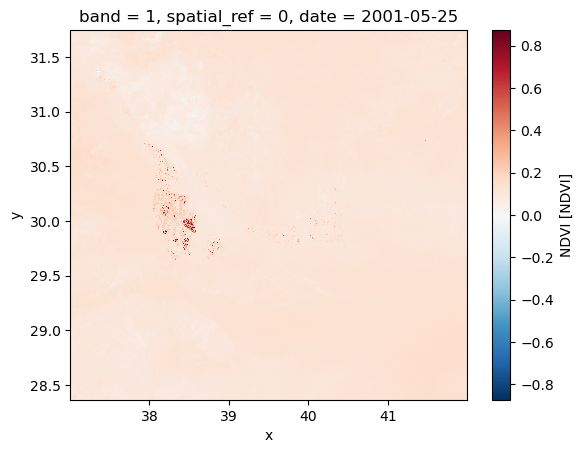

In [20]:
doy_start = -25
doy_end = -18

# Loop through each NDVI image
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    print(ndvi_path)
    #tell python where to find date locaiton in filename by indexing:
    date = pd.to_datetime(ndvi_path.name[doy_start:doy_end], format = '%Y%j')
    print(date)
    # Open dataset
    da = rxr.open_rasterio(ndvi_path, mask_and_scale = True).squeeze()
    display(da)
    da.plot
    
    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'
    display(da)
    da.plot()

    # Prepare for concatenation
    ndvi_das.append(da)
    break
ndvai_das

## Combine Rasters

Next, stack your arrays by date into a time series using the
`xr.combine_by_coords()` function. You will have to tell it which
dimension you want to stack your data in.

In [7]:
# Combine NDVI images from all dates

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [9]:
%store var1 var2

Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!